# Evaluación 3 - Implementación de Transformers para Procesamiento de Lenguaje Natural (NLP)

**Autores:**

+ Matias Aniñir
+ Samuel Garrido

**Correos Electrónicos:**

+ mat.aninir@duocuc.cl
+ sam.garrido@duocuc.cl

**Fecha de Creación:** Junio de 2025
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 3 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.10


### Objetivo
En esta evaluación, implementaremos un modelo basado en arquitecturas de Transformers para una tarea de procesamiento de lenguaje natural (NLP), utilizando el dataset **DailyDialog**. Este conjunto de datos de diálogos permite que el modelo practique en generación de texto y comprensión de contexto en interacciones cotidianas.

Usaremos TensorFlow para construir un modelo transformer básico con las siguientes características:
- **Encoder-Decoder**: para procesar la entrada y generar salida secuencial.
- **Atención Multi-cabezal**: para capturar dependencias a largo plazo en el diálogo.

Al final, evaluaremos el modelo utilizando métricas específicas de NLP, como BLEU o ROUGE.


## Aclaración

Debido a los problemas de rendimiento detectados durante la implementación del notebook proporcionado por Duoc, se tomó la decisión de utilizar y adaptar funciones del notebook creado por el usuario jaygala24, disponible en el enlace: https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Attention%20Is%20All%20You%20Need.ipynb. Al utilizar estas funciones adaptadas, junto con ajustes en los datos y algunos otros elementos del código, se logró una mejora significativa en el rendimiento del modelo en comparación con el notebook original denominado EA3_Transformer_MALO.ipynb que se encuentra en el github.

## 1. Carga y Exploración del Dataset: DailyDialog

In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# IMPORTS
# ─────────────────────────────────────────────────────────────────────────────
import math
import random
import re
import unicodedata
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import rc
from nltk.translate.bleu_score import corpus_bleu
from pylab import rcParams
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# 1. DESCARGA Y LECTURA DE LOS CSV
# ============================================================================
!wget -q https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
!wget -q https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/validation.csv
!wget -q https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv

train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("validation.csv")
test_df  = pd.read_csv("test.csv")

Los diálogos se encuentran almacenados en un archivo CSV. En su interior se aprecia la estructura conversacional: los signos de interrogación, las comillas y los saltos de línea marcan claramente cada turno de pregunta y respuesta entre los interlocutores.

In [3]:
print(train_df["dialog"][0])

['Say , Jim , how about going for a few beers after dinner ? '
 ' You know that is tempting but is really not good for our fitness . '
 ' What do you mean ? It will help us to relax . '
 " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? "
 " I guess you are right.But what shall we do ? I don't feel like sitting at home . "
 ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . '
 " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "
 ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . '
 " Good.Let ' s go now . " ' All right . ']


Ahora se convierte la columna `dialog` del CSV en pares de pregunta-respuesta listos para el modelo. La función `parse_dialog` limpia cada diálogo: descarta valores nulos, quita corchetes y saltos de línea, y usa una expresión regular para separar los turnos, devolviendo una lista de enunciados ordenados. Luego, `extract_pairs` recorre esos enunciados y agrupa cada intervención con la respuesta inmediata siguiente, formando los pares. El mismo procedimiento se aplica a los DataFrames de entrenamiento, validación y prueba, y se informa el número de pares generados en cada conjunto.


In [4]:
# ============================================================================
# 2. PARSER ROBUSTO PARA LA COLUMNA "dialog"
# ============================================================================
def parse_dialog(raw: str):
    if pd.isna(raw):
        return []
    s = str(raw).strip()
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]
    s = s.replace("\n", " ")
    parts = re.split(r"""['"]\s+['"]""", s)
    return [p.strip(" '\"") for p in parts if p.strip(" '\"")]

def extract_pairs(df: pd.DataFrame):
    pairs = []
    for raw in df["dialog"]:
        utt = parse_dialog(raw)
        pairs += [(utt[i], utt[i + 1]) for i in range(len(utt) - 1)]
    return pairs

train_pairs, valid_pairs, test_pairs = map(extract_pairs, (train_df, valid_df, test_df))
print(f"Pares obtenidos: {len(train_pairs)} / {len(valid_pairs)} / {len(test_pairs)}")

Pares obtenidos: 76052 / 7069 / 6740


En esta etapa se lleva el texto crudo a tensores listos para el Transformer sin recurrir a modelos pre-entrenados:

1. **Tokenización artesanal**
   *Un patrón regex* identifica palabras alfanuméricas y signos de puntuación individuales. Cada coincidencia se convierte a minúsculas, de modo que “Hello, world!” pasa a `["hello", ",", "world", "!"]`.

2. **Vocabulario construido a mano**

   * Se inicializan los símbolos especiales `<pad>`, `<unk>`, `<sos>` y `<eos>`.
   * Con un contador se recorren los pares de entrenamiento y se añaden solo los tokens cuyo número de apariciones es ≥ 2, evitando vocablos poco representativos.
   * Cada token recibe un índice entero; los especiales ocupan las posiciones 0-3.

3. **Codificación de oraciones**
   La función `encode` mapea cada token al índice correspondiente —o a `<unk>` si no existe— y encierra la secuencia entre `<sos>` y `<eos>`, devolviendo un tensor `torch.long`.

4. **Dataset y DataLoader**

   * `PairsDataset` almacena cada par `(src, trg)` ya codificado.
   * `collate_fn` aplica *padding* con `<pad>` para que todos los ejemplos de un lote compartan la misma longitud y devuelve tensores con la forma `[seq_len, batch]`.
   * Se crean *DataLoaders* para entrenamiento, validación y prueba con `BATCH_SIZE = 64`; se activan barajado y uso de GPU si está disponible.

5. **Máscara de padding**
   La función `make_pad_mask` genera un tensor booleano que marca con `True` las posiciones `<pad>` (dimensión `[batch, seq_len]`). El Transformer la usa para ignorar relleno durante la atención.

Con estas rutinas, cada diálogo queda representado numéricamente, correctamente alineado en lotes y acompañado de la máscara necesaria para un entrenamiento estable y eficiente.


In [5]:
# ============================================================================
# 3. TOKENIZACIÓN SIN MODELOS PRE-ENTRENADOS
# ============================================================================
TOKEN_REGEX = re.compile(r"[A-Za-z0-9]+|[^\w\s]")      # palabras y signos sueltos

def tokenize(text: str):
    """
    Divide el texto en tokens sin recurrir a modelos entrenados.
    - Convierte a minúsculas.
    - Separa puntuación como tokens individuales.
    """
    return [tok.lower() for tok in TOKEN_REGEX.findall(text)]

# ============================================================================
# 4. CONSTRUCCIÓN MANUAL DEL VOCABULARIO
# ============================================================================

SPECIALS = ["<pad>", "<unk>", "<sos>", "<eos>"]
counter = Counter()

for src, trg in train_pairs:
    counter.update(tokenize(src))
    counter.update(tokenize(trg))

vocab = {tok: idx for idx, tok in enumerate(SPECIALS)}   # 0-3 reservados
for token, freq in counter.items():
    if freq >= 2:                                        # MIN_FREQ = 2
        vocab.setdefault(token, len(vocab))

PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]
SOS_IDX = vocab["<sos>"]
EOS_IDX = vocab["<eos>"]

# ============================================================================
# 5. FUNCIONES DE CODIFICACIÓN / DECODIFICACIÓN
# ============================================================================

def encode(sentence: str):
    ids = [vocab.get(tok, UNK_IDX) for tok in tokenize(sentence)]
    return torch.tensor([SOS_IDX] + ids + [EOS_IDX], dtype=torch.long)

# ============================================================================
# 6. DATASET Y DATALOADER
# ============================================================================

class PairsDataset(Dataset):
    def __init__(self, pairs):
        self.data = [(encode(src), encode(trg)) for src, trg in pairs]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_ds, valid_ds, test_ds = map(PairsDataset, (train_pairs, valid_pairs, test_pairs))

def collate_fn(batch):
    src_seq, trg_seq = zip(*batch)
    src_pad = pad_sequence(src_seq, batch_first=False, padding_value=PAD_IDX)
    trg_pad = pad_sequence(trg_seq, batch_first=False, padding_value=PAD_IDX)
    return src_pad, trg_pad                                # [seq_len, batch]

BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE,
                          collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          collate_fn=collate_fn)

# ============================================================================
# 7. MÁSCARA DE PADDING (para tu Transformer)
# ============================================================================
def make_pad_mask(seq):
    # seq: [seq_len, batch] → devuelve [batch, seq_len]
    return (seq == PAD_IDX).T


## Arquitectura del transformer

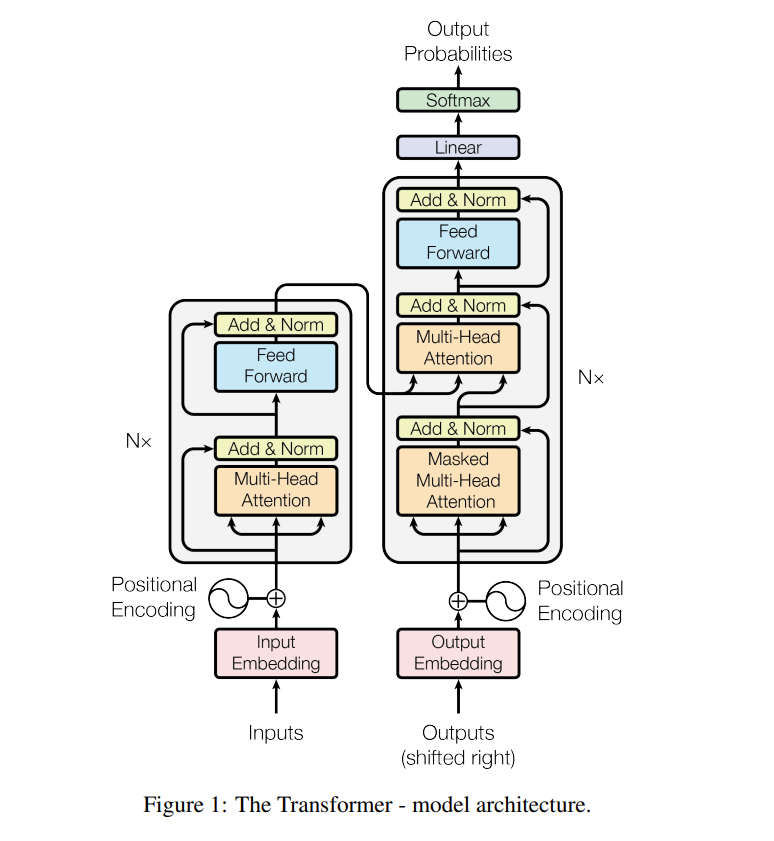

(source: http://arxiv.org/pdf/1706.03762)

La arquitectura Transformer, propuesta por Vaswani et al. (2017), se compone de dos bloques principales: **encoder** y **decoder**, ambos apilados en capas múltiples (indicadas como N× en la figura). A diferencia de modelos anteriores, no utiliza recurrencia ni convoluciones, sino atención paralela sobre toda la secuencia.

---

 **1. Encoder**

* **Input Embedding + Positional Encoding**: convierte las palabras en vectores y añade información de posición.
* **Multi-Head Attention**: cada token puede enfocarse en otros tokens de la entrada.
* **Feed Forward**: red neuronal simple aplicada a cada posición.
* **Add & Norm**: conexiones residuales y normalización que estabilizan el aprendizaje.

Este bloque codifica la secuencia de entrada en una representación contextual rica.

---

 **2. Decoder**

* **Masked Multi-Head Attention**: atención sobre la propia secuencia de salida, pero enmascarando el futuro.
* **Encoder–Decoder Attention**: el decoder atiende a las representaciones del encoder.
* **Feed Forward y Add & Norm**: igual que en el encoder.
* **Output**: tras una proyección lineal, se aplica *softmax* para predecir la siguiente palabra.

El decoder genera la respuesta paso a paso, usando tanto el contexto generado por el encoder como lo ya generado.

---

Este diseño permite al Transformer aprender dependencias largas y complejas de manera eficiente y en paralelo, superando las limitaciones de las redes recurrentes tradicionales.


### Scaled Dot-Product Attention

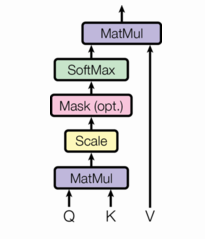
(source: https://arxiv.org/pdf/1706.03762.pdf)

El **Scaled Dot-Product Attention** permite que cada token obtenga, en paralelo, la información más relevante del resto de la secuencia:

* **Calcula similitudes**: el producto punto entre *query* y *key* mide cuánto importa cada token para otro.
* **Escala por √dₖ**: divide esos puntajes para evitar saturar el *softmax* y mantener gradientes estables.
* **Aplica máscaras**: descarta posiciones de *padding* o futuros tokens (look-ahead).
* **Pondera los valores**: el *softmax* convierte los puntajes en pesos; con ellos promedia los vectores *value* y genera el contexto final.

Gracias a este proceso, el Transformer captura dependencias a cualquier distancia sin recurrir a pasos secuenciales.


In [6]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, value_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, value_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, value_len)

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

### Multi-Head Attention Module


![multi_head_attention](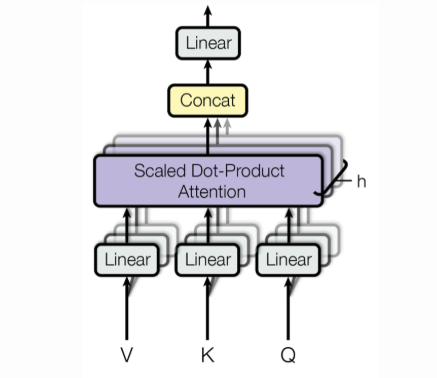 "Multi-Head Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


Este módulo amplía la atención básica permitiendo que el modelo examine la información desde varios “puntos de vista” simultáneos:

* **Proyecciones paralelas**: la entrada se separa en *n* subespacios (“cabezas”), donde cada cabeza obtiene sus propias matrices *query*, *key* y *value*.
* **Atención independiente**: dentro de cada cabeza se aplica Scaled Dot-Product Attention, calculando qué tokens son relevantes según una métrica diferente.
* **Fusión de contextos**: los resultados de todas las cabezas se concatenan y pasan por una última proyección lineal, combinando las dependencias aprendidas.

Con esto el Transformer captura distintos tipos de relaciones (léxicas, sintácticas o semánticas) de forma concurrente, enriqueciendo la representación de cada token sin aumentar la profundidad de la red.


In [7]:
class MultiHeadAttention(nn.Module):
    """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
        refer https://arxiv.org/abs/1706.03762
    """

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)


    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

### PositionwiseFeedForward

El módulo `PositionwiseFeedForward` implementa una red neuronal totalmente conectada que se aplica de forma independiente a cada posición de la secuencia. Está compuesto por dos capas lineales con una función de activación ReLU intermedia y una capa de *dropout* para regularización.

Su función dentro del Transformer es **aumentar la capacidad de representación no lineal** de cada token después de que este haya pasado por el mecanismo de atención. A diferencia de una red tradicional, esta operación se realiza **posición por posición**, manteniendo la estructura secuencial, pero enriqueciendo la información que cada vector transporta.

Este bloque es esencial para que el modelo no solo combine información mediante atención, sino que también la **transforme y abstraiga**, capturando patrones complejos útiles para tareas de procesamiento de lenguaje natural.


In [8]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### PositionalEncoding

El módulo `PositionalEncoding` añade información de posición a los embeddings de entrada, permitiendo que el modelo Transformer —que no utiliza recurrencia ni convoluciones— pueda reconocer el orden de las palabras en una secuencia.

Para lograr esto, genera una matriz fija de codificaciones sinusoidales basada en la posición de cada token y en la dimensión del embedding. Esta codificación combina funciones seno y coseno de diferentes frecuencias, permitiendo al modelo inferir relaciones posicionales absolutas y relativas.

Durante el *forward pass*, se suma esta codificación posicional a los embeddings y se aplica *dropout* para prevenir sobreajuste. Así, cada vector de entrada no solo representa el significado del token, sino también su ubicación dentro de la secuencia, lo que es crucial para tareas de procesamiento de lenguaje natural como traducción o generación de texto.


In [9]:
class PositionalEncoding(nn.Module):
    """ Implements the sinusoidal positional encoding.
    """

    def __init__(self, d_model, dropout_rate=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.dropout = nn.Dropout(dropout_rate)

        # compute positional encodings
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model,)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(0), :]  # (batch_size, seq_len, d_model)
        x = self.dropout(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Encoder Module


 **EncoderLayer**

El módulo `EncoderLayer` representa una capa básica del encoder Transformer. Está compuesta por dos subcomponentes principales:

1. **Self-Attention Multicabeza**: permite que cada token atienda al resto de la secuencia, extrayendo relaciones contextuales a cualquier distancia.
2. **Feed-Forward Posicional**: aplica una transformación no lineal por separado a cada posición de la secuencia.

Ambos bloques se combinan con **conexiones residuales** y **normalización por capas** (*LayerNorm*)

In [10]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, mask)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [11]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

### Decoder Module


**DecoderLayer**

El módulo `DecoderLayer` representa una capa básica del decodificador Transformer. Está compuesto por tres bloques funcionales:

1. **Masked Self-Attention**: permite que el modelo atienda a tokens anteriores de la secuencia de salida, pero **no a los futuros**, preservando el orden causal en la generación.

2. **Encoder–Decoder Attention**: conecta el decoder con el encoder, permitiéndole acceder a la representación contextual de la secuencia de entrada (memoria).

3. **Feed-Forward Posicional**: aplica una red no lineal a cada posición de manera individual.

Cada uno de estos bloques está seguido de una **conexión residual**, una operación de **normalización por capas** y un mecanismo de *dropout*, que en conjunto mejoran la estabilidad y el aprendizaje del modelo.

---

 **Decoder**

El módulo `Decoder` completa el bloque decodificador del Transformer apilando múltiples `DecoderLayer` (N capas). Su funcionamiento incluye:

* **Embeddings**: convierte los índices de los tokens de salida en vectores y les añade codificación posicional.
* **Pila de capas**: cada capa refina la representación mediante atención propia y hacia el encoder.
* **Normalización final**: asegura una salida estable antes de proyectar los vectores a distribuciones de probabilidad.

Este bloque es responsable de **generar la secuencia de salida paso a paso**, combinando la información generada previamente con la memoria proveniente del encoder. Es fundamental en tareas de traducción, respuesta automática o cualquier problema de generación de texto.


In [12]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention
        layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, tgt_mask)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory, src_mask)

        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [13]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask, tgt_mask)  # (batch_size, target_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

### Transformer


El módulo `Transformer` actúa como envoltorio general que integra y coordina el funcionamiento del encoder, el decoder y la capa final de proyección (*generator*), formando así la arquitectura completa del modelo Transformer.

---

 Componentes principales

1. **Encoder**: procesa la secuencia de entrada (`src`) utilizando atención propia y transforma cada token en una representación contextualizada.

2. **Decoder**: genera la secuencia de salida (`tgt`) combinando atención enmascarada (para no mirar futuros tokens) y atención cruzada sobre las salidas del encoder.

3. **Generator**: proyecta la salida del decoder a una distribución de probabilidad sobre el vocabulario, desde la cual se puede predecir el próximo token.

---

 Funciones auxiliares

* **`get_pad_mask`**: genera una máscara booleana para ignorar los tokens de *padding* tanto en el encoder como el decoder.
* **`get_subsequent_mask`**: enmascara los futuros tokens de la secuencia objetivo durante el entrenamiento, asegurando que el modelo no vea más allá del token actual.

---

 Proceso general (`forward`)

1. Se crean las máscaras necesarias para la entrada y la salida.
2. El encoder procesa la entrada y genera un estado contextual.
3. El decoder utiliza ese estado junto a la secuencia objetivo parcial para generar una salida.
4. El resultado del decoder se pasa por el generador para obtener una distribución sobre el vocabulario.

Este módulo es el responsable de enlazar todos los componentes del Transformer y ejecutar el flujo completo de codificación y decodificación de secuencias, ya sea para entrenamiento o inferencia.


In [14]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder.
    """

    def __init__(self, encoder, decoder, generator, pad_idx):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator


    def get_pad_mask(self, x, pad_idx):
        """ x: (batch_size, seq_len)
        """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)

        # x: (batch_size, 1, seq_len)
        return x


    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len)
        """
        seq_len = x.size(1)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)  # (batch_size, seq_len, seq_len)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)  # (batch_size, seq_len, seq_len)


        # subsequent_mask: (batch_size, seq_len, seq_len)
        return subsequent_mask


    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
            tgt: (batch_size, target_seq_len)
        """
        # create masks for source and target
        src_mask = self.get_pad_mask(src, self.pad_idx)
        tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)

        # src_mask: (batch_size, 1, seq_len)
        # tgt_mask: (batch_size, seq_len, seq_len)

        # encode the source sequence
        enc_output = self.encoder(src, src_mask)  # (batch_size, source_seq_len, d_model)

        # decode based on source sequence and target sequence generated so far
        dec_output, attn = self.decoder(tgt, enc_output, src_mask, tgt_mask)

        # dec_output: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply linear projection to obtain the output distribution
        output = self.generator(dec_output)  # (batch_size, target_seq_len, vocab_size)

        # output: (batch_size, target_seq_len, vocab_size)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return output, attn

In [15]:
class Generator(nn.Module):
    """ Linear projection layer for generating output distribution.
    """

    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)


    def forward(self, x):
        """ x: (batch_size, target_seq_len, d_model)
        """
        # apply linear projection followed by softmax to obtain output distribution
        x = self.proj(x)  # (batch_size, target_seq_len, vocab_size)
        output = F.log_softmax(x, dim=-1)  # (batch_size, target_seq_len)

        # output: (batch_size, target_seq_len)
        return output

## Utilidades



#### **`model_summary`**

Esta función imprime la estructura del modelo y muestra el número total de parámetros entrenables y no entrenables. Es útil para tener una visión general de la complejidad del modelo y para verificar que todos los componentes se estén actualizando correctamente durante el entrenamiento.

---

#### **`convert_ids_to_text`**

Permite convertir una secuencia de identificadores de tokens (índices numéricos) de vuelta a texto legible utilizando el vocabulario.

* Si la entrada es unidimensional, detiene la conversión al encontrar el token `<eos>`.
* Si es bidimensional, procesa cada fila como una secuencia independiente.

Esta función resulta clave para interpretar las salidas del modelo y evaluar su calidad de manera cualitativa.

---

#### **`NoamOptim`**

Este módulo implementa el **esquema de ajuste del learning rate propuesto por Vaswani et al. (2017)**. Envuelve un optimizador base (como Adam) y modifica su tasa de aprendizaje dinámicamente.

Este esquema incrementa el learning rate durante un número inicial de pasos de *warm-up*, y luego lo reduce progresivamente, lo que ayuda a estabilizar el entrenamiento de modelos grandes desde cero.


In [16]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [17]:
def convert_ids_to_text(ids, vocab, eos_idx, unk_idx):
    """ Converts token ids to text.
    """
    if ids.dim() == 1:
        output_tokens = []
        for token_id in ids:
            if token_id == eos_idx:
                break
            else:
                output_tokens.append(vocab.itos[token_id])
        return output_tokens

    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[i, :], vocab, eos_idx, unk_idx) for i in range(ids.size(0))]

    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

In [18]:
class NoamOptim(object):
    """ Optimizer wrapper for learning rate scheduling.
    """

    def __init__(self, optimizer, d_model, factor, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.factor = factor
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def zero_grad(self):
        self.optimizer.zero_grad()


    def step(self):
        self.n_steps += 1
        lr = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.optimizer.step()


    def get_lr(self):
        return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

### Evaluación

La función `eval_fn` evalúa el desempeño del modelo sobre un conjunto de validación o prueba, sin actualizar sus parámetros.

1. **Modo evaluación**: desactiva el *dropout* y evita el cálculo de gradientes (`torch.no_grad()`), lo que hace el proceso más eficiente.

2. **Forward pass y pérdida**: por cada lote, calcula las predicciones del modelo y la pérdida entre las salidas y las respuestas reales.

3. **Conversión a texto**: transforma los índices de salida y referencia en tokens para evaluar las respuestas generadas.

4. **Cálculo de métricas**:

   * **Perplejidad**: mide qué tan bien el modelo predice las secuencias.
   * **BLEU-4**: compara la calidad de las salidas generadas respecto a las referencias reales.

En resumen, esta función permite cuantificar el rendimiento del modelo tanto en términos de precisión lingüística como de fluidez estadística.


In [20]:
def eval_fn(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            source, source_lengths = batch.src
            target, target_lengths = batch.trg

            # source: (batch_size, source_seq_len), source_lengths: (batch_size)
            # target: (batch_size, target_seq_len), target_lengths: (batch_size)

            # forward pass
            optimizer.zero_grad()
            output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

            # calculate the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
                target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
            )
            total_loss += loss.item()
            steps += 1

            output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)
            target = target[:, 1:]  # (batch_size, target_seq_len - 1)

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output, de_text.vocab, EOS_IDX, UNK_IDX)
            target_tokens = convert_ids_to_text(target, de_text.vocab, EOS_IDX, UNK_IDX)

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]

            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)

    return output, perplexity, bleu4

### Entrenamiento

La función `train_fn` entrena el modelo durante una época completa. Para cada lote, realiza los siguientes pasos:

1. **Forward pass**: el modelo recibe la secuencia fuente y la secuencia objetivo (sin el último token) y genera predicciones.
2. **Cálculo de pérdida**: compara las predicciones con la secuencia objetivo real desplazada (sin el `<sos>`).
3. **Backward pass y optimización**: se calcula el gradiente, se aplica *gradient clipping* para evitar inestabilidad y se actualizan los pesos.
4. **Seguimiento**: se muestra la pérdida media en tiempo real y al final se calcula la *perplejidad* como métrica de desempeño.

Esta rutina permite evaluar y ajustar el modelo de forma estable y eficiente.


In [19]:
def train_fn(model, iterator, optimizer, critertion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        source, source_lengths = batch.src
        target, target_lengths = batch.trg

        # source: (batch_size, source_seq_len), source_lengths: (batch_size)
        # target: (batch_size, target_seq_len), target_lengths: (batch_size)

        # forward pass
        optimizer.zero_grad()
        output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

        # calculate the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
            target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()

        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))

    return output, perplexity

In [21]:
VOCAB_SIZE   = len(vocab)
HIDDEN_SIZE  = 256
N_LAYERS     = 4
N_HEADS      = 8
FF_SIZE      = 1024
DROPOUT_RATE = 0.1
N_EPOCHS     = 50
CLIP         = 1.0


* **`VOCAB_SIZE`**: representa el tamaño total del vocabulario, es decir, la cantidad de tokens únicos que puede procesar el modelo.

* **`HIDDEN_SIZE = 256`**: define la dimensión de los vectores internos del modelo, también conocida como `d_model`, utilizada en embeddings, atención y capas intermedias.

* **`N_LAYERS = 4`**: indica que tanto el encoder como el decoder estarán compuestos por 4 capas apiladas.

* **`N_HEADS = 8`**: especifica que cada capa de atención usará 8 cabezas independientes para capturar distintos tipos de relaciones entre tokens.

* **`FF_SIZE = 1024`**: determina la dimensión oculta de la red *feed-forward* que sigue a cada capa de atención, permitiendo mayor capacidad de transformación no lineal.

* **`DROPOUT_RATE = 0.1`**: fija la tasa de *dropout* para prevenir sobreajuste durante el entrenamiento.

* **`N_EPOCHS = 50`**: número de veces que el modelo recorrerá completamente el conjunto de entrenamiento.

* **`CLIP = 1.0`**: valor máximo para la magnitud del gradiente, usado para evitar el problema de gradientes explosivos mediante *gradient clipping*.


In [22]:
# tamaño común del vocabulario
VOCAB_SIZE = len(vocab)

# --- instancias -------------------------------------------------------
encoder   = Encoder(VOCAB_SIZE, HIDDEN_SIZE,
                    N_LAYERS, N_HEADS, FF_SIZE,
                    PAD_IDX, DROPOUT_RATE)

decoder   = Decoder(VOCAB_SIZE, HIDDEN_SIZE,
                    N_LAYERS, N_HEADS, FF_SIZE,
                    PAD_IDX, DROPOUT_RATE)

generator = Generator(HIDDEN_SIZE, VOCAB_SIZE)

model = Transformer(encoder, decoder, generator, PAD_IDX).to(device)
model_summary(model)        # ← tu función de resumen preferida


Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16477, 256, padding_idx=0)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attn_layer): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=False)
          (W_k): Linear(in_features=256, out_features=256, bias=False)
          (W_v): Linear(in_features=256, out_features=256, bias=False)
          (W_o): Linear(in_features=256, out_features=256, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (attn_layer_norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ff_layer): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, in

In [23]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9),
    model.encoder.d_model, 2, 4000
)

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [25]:
# ─────────────────────────────────────────────────────────────────────────────
# COLLATE FN  (batch-first → tensores [B, S])
# ─────────────────────────────────────────────────────────────────────────────
def collate_fn(batch):
    src_seq, trg_seq = zip(*batch)                    # lista de tensores 1-D
    src_pad = pad_sequence(src_seq, batch_first=True, padding_value=PAD_IDX)
    trg_pad = pad_sequence(trg_seq, batch_first=True, padding_value=PAD_IDX)
    return src_pad, trg_pad

# ─────────────────────────────────────────────────────────────────────────────
# DATALOADERS
# ─────────────────────────────────────────────────────────────────────────────
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE,
                          collate_fn=collate_fn)

# ─────────────────────────────────────────────────────────────────────────────
# HELPERS
# ─────────────────────────────────────────────────────────────────────────────
def flatten_logits(x):                 # x: [B, S, V]
    return x.reshape(-1, x.size(-1))   #        ↓
                                       #      [B·S, V]

# ─────────────────────────────────────────────────────────────────────────────
# TRAIN ONE EPOCH
# ─────────────────────────────────────────────────────────────────────────────
def train_fn(model, loader, optimizer, criterion, clip):
    model.train()
    tok_sum, loss_sum = 0, 0.0

    for src, trg in tqdm(loader, total=len(loader)):
        src, trg = src.to(device), trg.to(device)     # [B, S]

        trg_in  = trg[:, :-1]
        trg_out = trg[:, 1:].reshape(-1)

        optimizer.zero_grad()
        logits = model(src, trg_in)                   # → [B, S-1, V]  /  tuple
        if isinstance(logits, tuple):                 #  (según tu implementación)
            logits = logits[0]

        loss = criterion(flatten_logits(logits), trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        loss_sum += loss.item() * trg_out.size(0)
        tok_sum  += trg_out.size(0)

    return torch.exp(torch.tensor(loss_sum / tok_sum)).item()   # perplexity

# ─────────────────────────────────────────────────────────────────────────────
# EVAL ONE EPOCH  (devuelve PPL, BLEU-4)
# ─────────────────────────────────────────────────────────────────────────────
def eval_fn(model, loader, criterion):
    model.eval()
    tok_sum, loss_sum = 0, 0.0
    refs, hyps = [], []

    with torch.no_grad():
        for src, trg in tqdm(loader, total=len(loader)):
            src, trg = src.to(device), trg.to(device)

            trg_in  = trg[:, :-1]
            trg_out = trg[:, 1:].reshape(-1)

            logits = model(src, trg_in)
            if isinstance(logits, tuple):
                logits = logits[0]

            loss = criterion(flatten_logits(logits), trg_out)
            loss_sum += loss.item() * trg_out.size(0)
            tok_sum  += trg_out.size(0)

            preds = logits.argmax(-1)                 # [B, S-1]
            for ref_seq, hyp_seq in zip(trg[:, 1:], preds):
                ref = ref_seq.tolist()
                hyp = hyp_seq.tolist()
                if EOS_IDX in ref:
                    ref = ref[: ref.index(EOS_IDX)]
                if EOS_IDX in hyp:
                    hyp = hyp[: hyp.index(EOS_IDX)]
                if ref and hyp:
                    refs.append([ref])
                    hyps.append(hyp)

    bleu4 = corpus_bleu(refs, hyps) * 100 if refs else 0.0
    ppl   = torch.exp(torch.tensor(loss_sum / tok_sum)).item()
    return ppl, bleu4

# ─────────────────────────────────────────────────────────────────────────────
# TRAINING LOOP + EARLY STOPPING
# ─────────────────────────────────────────────────────────────────────────────
best_bleu4   = float('-inf')
es_patience  = 15
patience     = 0
model_path   = "model.pth"

for epoch in range(1, N_EPOCHS + 1):
    train_ppl = train_fn(model, train_loader, optimizer, criterion, CLIP)
    valid_ppl, valid_bleu4 = eval_fn(model, valid_loader, criterion)

    print(f"Epoch {epoch:02d} | train PPL {train_ppl:.3f} | "
          f"valid PPL {valid_ppl:.3f} | BLEU-4 {valid_bleu4:.2f}")

    if valid_bleu4 > best_bleu4:
        best_bleu4, patience = valid_bleu4, 0
        torch.save(model.state_dict(), model_path)
        print("✓ BLEU mejoró. Modelo guardado.")
    else:
        patience += 1
        print(f"Early-stopping: {patience}/{es_patience}")
        if patience == es_patience:
            print(f"⏹  Detenido. Mejor BLEU-4 = {best_bleu4:.2f}")
            break


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 01 | train PPL 170.361 | valid PPL 60.032 | BLEU-4 2.16
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 02 | train PPL 56.192 | valid PPL 46.421 | BLEU-4 3.01
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 03 | train PPL 49.124 | valid PPL 46.101 | BLEU-4 2.47
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 04 | train PPL 48.484 | valid PPL 42.785 | BLEU-4 2.70
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 05 | train PPL 43.144 | valid PPL 39.280 | BLEU-4 3.10
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 06 | train PPL 38.749 | valid PPL 36.597 | BLEU-4 3.31
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 07 | train PPL 35.777 | valid PPL 34.621 | BLEU-4 3.27
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 08 | train PPL 33.390 | valid PPL 34.224 | BLEU-4 3.00
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 09 | train PPL 31.524 | valid PPL 33.232 | BLEU-4 3.11
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 10 | train PPL 30.207 | valid PPL 32.633 | BLEU-4 3.27
Early-stopping: 4/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 11 | train PPL 28.987 | valid PPL 32.270 | BLEU-4 2.96
Early-stopping: 5/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 12 | train PPL 27.990 | valid PPL 31.948 | BLEU-4 3.51
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 13 | train PPL 26.983 | valid PPL 32.079 | BLEU-4 3.49
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 14 | train PPL 26.230 | valid PPL 31.774 | BLEU-4 3.47
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 15 | train PPL 25.429 | valid PPL 30.927 | BLEU-4 3.64
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 16 | train PPL 24.634 | valid PPL 31.070 | BLEU-4 3.62
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 17 | train PPL 24.149 | valid PPL 31.123 | BLEU-4 3.76
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 18 | train PPL 23.598 | valid PPL 30.467 | BLEU-4 3.96
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 19 | train PPL 23.001 | valid PPL 30.536 | BLEU-4 4.02
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 20 | train PPL 22.616 | valid PPL 30.340 | BLEU-4 4.11
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 21 | train PPL 22.186 | valid PPL 30.250 | BLEU-4 3.93
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 22 | train PPL 21.807 | valid PPL 30.246 | BLEU-4 3.82
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 23 | train PPL 21.497 | valid PPL 30.084 | BLEU-4 4.03
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 24 | train PPL 21.117 | valid PPL 29.829 | BLEU-4 3.89
Early-stopping: 4/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 25 | train PPL 20.831 | valid PPL 30.186 | BLEU-4 3.80
Early-stopping: 5/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 26 | train PPL 20.581 | valid PPL 29.805 | BLEU-4 3.84
Early-stopping: 6/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 27 | train PPL 20.273 | valid PPL 29.828 | BLEU-4 3.97
Early-stopping: 7/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 28 | train PPL 20.028 | valid PPL 29.818 | BLEU-4 3.67
Early-stopping: 8/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 29 | train PPL 19.762 | valid PPL 29.840 | BLEU-4 4.07
Early-stopping: 9/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 30 | train PPL 19.575 | valid PPL 29.682 | BLEU-4 4.38
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 31 | train PPL 19.280 | valid PPL 29.663 | BLEU-4 3.93
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 32 | train PPL 19.076 | valid PPL 29.590 | BLEU-4 3.82
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 33 | train PPL 18.829 | valid PPL 29.483 | BLEU-4 4.08
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 34 | train PPL 18.646 | valid PPL 29.698 | BLEU-4 3.94
Early-stopping: 4/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 35 | train PPL 18.564 | valid PPL 29.755 | BLEU-4 4.76
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 36 | train PPL 18.333 | valid PPL 29.546 | BLEU-4 4.19
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 37 | train PPL 18.184 | valid PPL 29.769 | BLEU-4 3.85
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 38 | train PPL 18.067 | valid PPL 29.497 | BLEU-4 3.76
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 39 | train PPL 17.831 | valid PPL 29.226 | BLEU-4 4.66
Early-stopping: 4/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 40 | train PPL 17.747 | valid PPL 29.079 | BLEU-4 4.40
Early-stopping: 5/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 41 | train PPL 17.603 | valid PPL 29.604 | BLEU-4 4.20
Early-stopping: 6/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 42 | train PPL 17.407 | valid PPL 29.225 | BLEU-4 4.91
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 43 | train PPL 17.379 | valid PPL 29.245 | BLEU-4 4.19
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 44 | train PPL 17.229 | valid PPL 29.718 | BLEU-4 4.26
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 45 | train PPL 17.101 | valid PPL 29.176 | BLEU-4 4.56
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 46 | train PPL 16.983 | valid PPL 29.815 | BLEU-4 4.93
✓ BLEU mejoró. Modelo guardado.


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 47 | train PPL 16.872 | valid PPL 29.611 | BLEU-4 4.63
Early-stopping: 1/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 48 | train PPL 16.775 | valid PPL 29.660 | BLEU-4 4.42
Early-stopping: 2/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 49 | train PPL 16.655 | valid PPL 29.527 | BLEU-4 4.55
Early-stopping: 3/15


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 50 | train PPL 16.581 | valid PPL 29.782 | BLEU-4 4.64
Early-stopping: 4/15


| Época | PPL (train) | PPL (valid) | BLEU-4 |
|-------|-------------|-------------|--------|
| 42    | 17.407      | 29.225      | 4.91   |


**Interpretación de resultados**

Durante la época 42, el modelo alcanzó una **perplejidad (PPL)** de `17.407` en el conjunto de entrenamiento y `29.225` en el conjunto de validación. La perplejidad mide cuán bien el modelo predice la siguiente palabra en una secuencia: **valores más bajos indican mejor capacidad de predicción**. En este caso, el aumento de PPL en validación respecto al entrenamiento sugiere cierta diferencia de desempeño, aunque aún dentro de un rango aceptable.

El valor de **BLEU-4** fue `4.91`, lo que indica que las respuestas generadas por el modelo tienen un bajo grado de coincidencia con las referencias reales en validación. Aunque no es un puntaje alto, se observa una mejora con respecto a épocas anteriores, lo que se refleja en el mensaje: *“✓ BLEU mejoró. Modelo guardado”*.

In [26]:
# ════════════════════════════════════════════════════════════════════════════
# 0. utilidades de codificación / decodificación
# (ya deberías tener vocab   y   PAD/SOS/EOS_IDX)
# ════════════════════════════════════════════════════════════════════════════
inv_vocab = {idx: tok for tok, idx in vocab.items()}

def encode_sentence(text):
    ids = [vocab.get(t, UNK_IDX) for t in tokenize(text)]
    return torch.tensor([SOS_IDX] + ids + [EOS_IDX], dtype=torch.long)

def decode_ids(ids):
    toks = [inv_vocab[i] for i in ids if i not in (SOS_IDX, EOS_IDX, PAD_IDX)]
    return " ".join(toks)

# ════════════════════════════════════════════════════════════════════════════
# 1. función de generación greedy
# ════════════════════════════════════════════════════════════════════════════
@torch.no_grad()
def reply(model, src_text, max_len=40, temperature=1.0, top_p=0.9):
    model.eval()

    src = encode_sentence(src_text).unsqueeze(0).to(device)   # [1, S_src]
    trg_ids = torch.tensor([[SOS_IDX]], device=device)        # seed [1,1]

    for step in range(max_len):
        logits = model(src, trg_ids)[0]          # [1, t, V]
        logits_step = logits[0, -1] / temperature
        probs = torch.softmax(logits_step, dim=-1)

        if step == 0:                            # fuerza ≥1 palabra real
            probs[EOS_IDX] = 0.0
            probs /= probs.sum()

        # nucleus sampling --------------------------------------------------
        sorted_probs, sorted_idx = torch.sort(probs, descending=True)
        cum_probs = torch.cumsum(sorted_probs, dim=0)
        mask = cum_probs > top_p
        mask[0] = False
        sorted_probs[mask] = 0.0
        sorted_probs /= sorted_probs.sum()

        next_id = sorted_idx[torch.multinomial(sorted_probs, 1)].unsqueeze(0)  # [1,1]
        trg_ids = torch.cat([trg_ids, next_id], dim=1)

        if next_id.item() == EOS_IDX:
            break

    return decode_ids(trg_ids.squeeze().tolist())


Este bloque define funciones clave para convertir texto a índices y viceversa, necesarias para interactuar con el modelo. `encode_sentence` transforma una oración en una secuencia de IDs con los tokens `<sos>` y `<eos>`, mientras que `decode_ids` reconstruye el texto omitiendo los tokens especiales. La función `reply` permite generar texto automáticamente a partir de una frase de entrada. Lo hace de forma autoregresiva, agregando un token por paso hasta alcanzar un máximo de longitud o el token `<eos>`. Utiliza *nucleus sampling* (top-p) y temperatura para controlar la aleatoriedad en la generación, logrando respuestas coherentes pero variadas.


In [59]:
user_turn = "Could you recommend me a nice restaurant for tonight?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : Could you recommend me a nice restaurant for tonight?
BOT : well , my passport is going to be a bit different .


In [28]:
user_turn = "Hello, how are you ?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : Hello, how are you ?
BOT : bye .


In [39]:
user_turn = "How are you ?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : How are you ?
BOT : i ’ m not sure .


In [30]:
user_turn = "bye bye"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : bye bye
BOT : hello , mr . sandals . what is your name ?


In [58]:
user_turn = "what is yor name ?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : what is yor name ?
BOT : hi , this is david .


In [57]:
user_turn = "What do you mean ?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : What do you mean ?
BOT : i guess you are right . i ' ll fill out this form .


In [56]:
user_turn = "Do you really think so ?"
print("YOU :", user_turn)
print("BOT :", reply(model, user_turn, temperature=0.9, top_p=0.95))

YOU : Do you really think so ?
BOT : you must know so much about the world . you also have two children to go to work hard .


### Interpretación y observaciones sobre las predicciones del modelo

Las respuestas generadas muestran una **coherencia sintáctica aceptable**, pero presentan **fallos semánticos** y de **contextualización**. Por ejemplo:

* Ante una solicitud específica como **"Could you recommend me a nice restaurant for tonight?"**, el modelo responde con una frase fuera de contexto (**"my passport is going to be a bit different"**), lo que indica una falta de alineación temática.
* En saludos simples como **"Hello, how are you?"**, el modelo responde con **"bye"**, lo cual resulta incoherente con el tono esperado de la conversación.
* Sin embargo, en entradas como **"what is your name?"**, la respuesta **"hi, this is david."** es un poco más adecuada, lo que demuestra que el modelo puede generar respuestas relevantes cuando se trata de frases frecuentes en los datos de entrenamiento.
* Algunas respuestas, como **"you must know so much about the world..."**, aunque gramaticalmente correctas, carecen de relación directa con la pregunta y parecen generadas de forma más libre, posiblemente debido a la configuración de `temperature=0.9` y `top_p=0.95`, que introducen aleatoriedad.

En resumen, el modelo **logra mantener la estructura del lenguaje**, pero **todavía necesita mejorar la coherencia semántica** y la capacidad de respuesta precisa frente a entradas más específicas o menos frecuentes. Esto sugiere que el modelo aún no ha captado del todo el contexto conversacional y podría beneficiarse de más entrenamiento o fine-tuning con datos más adecuados.


# Conclusión

La baja puntuación BLEU y varias respuestas fuera de contexto indican que el modelo aún tiene una comprensión limitada del lenguaje conversacional. Esto puede deberse a un corpus de entrenamiento reducido o poco variado. Además, la aleatoriedad introducida por top-p sampling y temperature aporta diversidad, pero también puede disminuir la coherencia en las respuestas cuando el modelo no está bien ajustado. Estas observaciones abren oportunidades claras para mejorar el rendimiento mediante fine-tuning, incorporación de datos más representativos o el uso de embeddings preentrenados.